In [2]:
from __future__ import absolute_import, division, print_function

%matplotlib inline
# %matplotlib nbagg
import tensorflow as tf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from data_generator_tensorflow import get_batch, print_valid_characters

import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils 

import tf_utils

# Recurrent Neural Networks
> <span style="color:gray">
Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow by 
Alexander R. Johansen ([alrojo](https://github.com/alrojo)), 
and updated by 
Toke Faurby ([faur](https://github.com/Faur)).
> </span>

Recurrent neural networks (RNN) are the natural type of neural network to use for sequential data e.g. time series analysis, translation, speech recognition, biological sequence analysis etc.
RNNs works by recursively applying the same operation to an input $x_t$ and its own hidden state from the previous timestep $h_{t-1}$.
That is to say that each layer can be described by the function $f$:

$$y_t, h_t = f(x_t, h_{t-1})$$

where $y_t$ is the output.
An RNN can therefore handle input of varying length.

Drawing all the connections in a RNN (left) quickly becomes messy, therefore it is common to use the time unrolled view (right) when representing RNNs.
<img src='images/rnn_basic.png', width=600>
*Image by [Alex Graves](https://www.cs.toronto.edu/~graves/preprint.pdf)*



#### External resources
* The code describing RNNs can be tricky to understand at first. 
R2T2 has a great tutorial series ([part 1](https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html), [part 2](https://r2rt.com/recurrent-neural-networks-in-tensorflow-ii.html)) that digs into the details of how RNNs are implemented in TensorFlow. This introduction is heavily inspired by part 1.
* For more in depth background material on RNNs please see [Supervised Sequence Labelling with Recurrent
Neural Networks](https://www.cs.toronto.edu/~graves/preprint.pdf) by Alex Graves
* Lastly there is an [official TensorFlow tutorial](https://www.tensorflow.org/tutorials/recurrent) that is also worth a look

# Encoder-Decoder Models


Recurrent networks can be used for several kinds of prediction tasks including: 
* **One-to-one** - NOT a recurrent network. E.g. image classification.
* **One-to-many** - E.g. creating an [image caption](http://cs.stanford.edu/people/karpathy/deepimagesent/) with an RNN.
* **Many-to-one** - E.g. sentiment analysis of text.
* **Many-to-many** (different lengths) This is a combination of the *one-to-many* and *many-to-One*, and is called an **encoder-decoder** RNN. E.g. machine translation.
* **Many-to-many** (same length) Each input has an output. E.g. robotics control.


<img src="images/types.jpeg", width=800>

*Image courtesy Andrej Karpathy's [blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*



## Encoder-Decoder
In this exercise we'll implement a Encoder-Decoder RNN based for a simple sequence to sequence translation task.
We will use a special kind of unit, called the GRU unit.
The GRU unit stores a hidden value per neuron that helps it '*remember*' long-term dependencies.
Another popular choice of unit type is LSTM, which store two values, but these are approximately twice as slow as GRU.
GRUs (and LSTMs) can be difficult to understand at first.
For a very good not-to-mathematical introduction see 
[Chris Olahs blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) or
[Andrej Karpathys blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
(All their posts are nice and cover various topics within machine-learning).
This type of models have shown impressive performance in Neural Machine Translation and Image Caption generation. 


In the encoder-decoder structure one RNN (blue) encodes the input into a hidden representation, and a second RNN (red) uses this representation to predict the target values.
An essential step is deciding how the encoder and decoder should communicate.
In the simplest approach you use the last hidden state of the encoder to initialize the decoder.
This is what we will do in this notebook, as shown here:

<img src='images/enc-dec.png', width=400>

#### Teacher forcing
We will also use what is called *teacher forcing*.
This is shown as the gray lines in the figure.
This means that the RNN will implement a sequence of conditional distributions so the $t$th output of the decoder gives $p(y_t|y_1,\dots,y_{t-1} ,x)$. This formulation will make the task easier and faster for the network to learn because it during training always have access to the correct preceding outputs.
A test time where we we don't know the output sequence we have to predict one step at a time. 
There is no guarantee that we will find the mostly likely decoded *sequence*. A technique called [beam search](https://arxiv.org/pdf/1702.01806.pdf) is used in machine translation and related tasks to look for list of candidate decoded sequences.    



#### Alternatives
There are other ways to let the encoder and decoder communicate with each other.
For instance you can give the last state of the Encoder as input to the Decoder at each decode time step, not just the previously predicted word.
Another approache is called **attention**, which lets the Decoder attend to different parts of the encoded input at different timesteps in the decoding process. 
Attention is shown in the next notebook. 



### The Data
Since RNN models can be very slow to train on real large datasets we will generate some simpler training data for this exercise. The task for the RNN is simply to translate a string of letters spelling the numbers between 0-9 into the corresponding numbers i.e

    "one two five" --> "125#"

`#` is a special end-of-sequence character, indicating the sequence is done.

To input the strings into the RNN model we translate the characters into a vector integers using a simple translation table (i.e. 'h'->16, 'o'-> 17 etc).
The code below prints a few input/output pairs using the *get_batch* function which randomy produces the data.


In the data loader below will setup the data and print some information. 
Key to understand are:
 * ENCODED INPUTS (`inputs`) are feed into the encoder (`A B C D` in the figure)
 * ENCODED TARGETS OUTPUT (`targets_out`) are what we want the network to predict. This is used to compute the error. (`X Y Z EOS` in the figure) 
 * ENCODED TARGETS INPUT (`targets_in`) are used for teacher forcing during training. (`EOS X Y Z` in the figure) 
 
Note; that we use the same symbol for end-of-sequence as for start-of-sequence (`#`).


In [3]:
# At the bottom of the script there is some code which saves the model.
# If you wish to restore your model from a previous state use this function.
load_model = False

In [4]:
batch_size = 3
inputs, inputs_seqlen, targets_in, targets_out, targets_seqlen, targets_mask, \
text_inputs, text_targets_in, text_targets_out = \
    get_batch(batch_size=batch_size, max_digits=4, min_digits=2)

print("input types:", inputs.dtype, inputs_seqlen.dtype, targets_in.dtype, targets_out.dtype, targets_seqlen.dtype)
print_valid_characters()
print("Stop/start character = #")

for i in range(batch_size):
    print("\nSAMPLE",i)
    print("TEXT INPUTS:\t\t\t", text_inputs[i])
    print("ENCODED INPUTS:\t\t\t", inputs[i])
    print("INPUTS SEQUENCE LENGTH:\t\t", inputs_seqlen[i])
    print("TEXT TARGETS OUTPUT:\t\t", text_targets_out[i])
    print("TEXT TARGETS INPUT:\t\t", text_targets_in[i])
    print("ENCODED TARGETS OUTPUT:\t\t", targets_out[i])
    print("ENCODED TARGETS INPUT:\t\t", targets_in[i])
    print("TARGETS SEQUENCE LENGTH:\t", targets_seqlen[i])
    print("TARGETS MASK:\t\t\t", targets_mask[i])

input types: int32 int32 int32 int32 int32
Number of valid characters: 27
'0'=0,	'1'=1,	'2'=2,	'3'=3,	'4'=4,	'5'=5,	'6'=6,	'7'=7,	'8'=8,	'9'=9,	'#'=10,	'u'=11,	's'=12,	'x'=13,	'z'=14,	'w'=15,	'h'=16,	'g'=17,	'i'=18,	'f'=19,	'e'=20,	'r'=21,	' '=22,	'v'=23,	'n'=24,	'o'=25,	't'=26,	
Stop/start character = #

SAMPLE 0
TEXT INPUTS:			 two six six
ENCODED INPUTS:			 [26 15 25 22 12 18 13 22 12 18 13  0  0]
INPUTS SEQUENCE LENGTH:		 11
TEXT TARGETS OUTPUT:		 266#
TEXT TARGETS INPUT:		 #266
ENCODED TARGETS OUTPUT:		 [ 2  6  6 10]
ENCODED TARGETS INPUT:		 [10  2  6  6]
TARGETS SEQUENCE LENGTH:	 4
TARGETS MASK:			 [ 1.  1.  1.  1.]

SAMPLE 1
TEXT INPUTS:			 one seven one
ENCODED INPUTS:			 [25 24 20 22 12 20 23 20 24 22 25 24 20]
INPUTS SEQUENCE LENGTH:		 13
TEXT TARGETS OUTPUT:		 171#
TEXT TARGETS INPUT:		 #171
ENCODED TARGETS OUTPUT:		 [ 1  7  1 10]
ENCODED TARGETS INPUT:		 [10  1  7  1]
TARGETS SEQUENCE LENGTH:	 4
TARGETS MASK:			 [ 1.  1.  1.  1.]

SAMPLE 2
TEXT INPUTS:			 five nine
ENCODED 

### Encoder-Decoder model setup
Below is the TensorFlow model definition. We use an embedding layer to go from integer representation to vector representation of the input.

TensorFlow has implementations of LSTM and GRU units.
Both implementations assume that the input from the tensor below has the shape **`[batch_size, max_time, input_size]`**, (unless you have `time_major=True`, in which case it is `[max_time, batch_size, input_size]`).

Note that we have made use of a custom decoder wrapper which can be found in `tf_utils.py`.

In [5]:
# resetting the graph
tf.reset_default_graph()

# Setting up hyperparameters and general configs
MAX_DIGITS = 10
MIN_DIGITS = 5
NUM_INPUTS = 27
NUM_OUTPUTS = 11 #(0-9 + '#')

BATCH_SIZE = 16
# try various learning rates 1e-2 to 1e-5
LEARNING_RATE = 0.005
X_EMBEDDINGS = 8
t_EMBEDDINGS = 8
NUM_UNITS_ENC = 16
NUM_UNITS_DEC = 16


# Setting up placeholders, these are the tensors that we "feed" to our network
Xs = tf.placeholder(tf.int32, shape=[None, None], name='X_input')
ts_in = tf.placeholder(tf.int32, shape=[None, None], name='t_input_in')
ts_out = tf.placeholder(tf.int32, shape=[None, None], name='t_input_out')
X_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_mask = tf.placeholder(tf.float32, shape=[None, None], name='t_mask')


### Building the model
# first we build the embeddings to make our characters into dense, trainable vectors
X_embeddings = tf.get_variable('X_embeddings', [NUM_INPUTS, X_EMBEDDINGS],
                               initializer=tf.random_normal_initializer(stddev=0.1))
t_embeddings = tf.get_variable('t_embeddings', [NUM_OUTPUTS, t_EMBEDDINGS],
                               initializer=tf.random_normal_initializer(stddev=0.1))

X_embedded = tf.gather(X_embeddings, Xs, name='embed_X')
t_embedded = tf.gather(t_embeddings, ts_in, name='embed_t')


## forward encoding
enc_cell = tf.nn.rnn_cell.GRUCell(NUM_UNITS_ENC)
_, enc_state = tf.nn.dynamic_rnn(cell=enc_cell, inputs=X_embedded,
                                 sequence_length=X_len, dtype=tf.float32)
# use below incase TF's makes issues
# enc_state, _ = tf_utils.encoder(X_embedded, X_len, 'encoder', NUM_UNITS_ENC)
#
# enc_state = tf.concat(1, [enc_state, enc_state])

## decoding
# note that we are using a wrapper for decoding here, this wrapper is hardcoded to only use GRU
# check out tf_utils to see how you make your own decoder

# setting up weights for computing the final output
W_out = tf.get_variable('W_out', [NUM_UNITS_DEC, NUM_OUTPUTS])
b_out = tf.get_variable('b_out', [NUM_OUTPUTS])

dec_out, valid_dec_out = tf_utils.decoder(enc_state, t_embedded, t_len, 
                                          NUM_UNITS_DEC, t_embeddings,
                                          W_out, b_out)

## reshaping to have [batch_size*seqlen, num_units]
out_tensor = tf.reshape(dec_out, [-1, NUM_UNITS_DEC])
valid_out_tensor = tf.reshape(valid_dec_out, [-1, NUM_UNITS_DEC])
# computing output
out_tensor = tf.matmul(out_tensor, W_out) + b_out
valid_out_tensor = tf.matmul(valid_out_tensor, W_out) + b_out

## reshaping back to sequence
# print('X_len', tf.shape(X_len)[0])
b_size = tf.shape(X_len)[0] # use a variable we know has batch_size in [0]
seq_len = tf.shape(t_embedded)[1] # variable we know has sequence length in [1]
num_out = tf.constant(NUM_OUTPUTS) # casting NUM_OUTPUTS to a tensor variable
out_shape = tf.concat([tf.expand_dims(b_size, 0),
                      tf.expand_dims(seq_len, 0),
                      tf.expand_dims(num_out, 0)],
                     axis=0)

out_tensor = tf.reshape(out_tensor, out_shape)
valid_out_tensor = tf.reshape(valid_out_tensor, out_shape)
# handling shape loss
#out_tensor.set_shape([None, None, NUM_OUTPUTS])
y = out_tensor
y_valid = valid_out_tensor

In [6]:
# print all the variable names and shapes
for var in tf.global_variables ():
    s = var.name + " "*(40-len(var.name))
    print(s, var.value().get_shape())

X_embeddings:0                           (27, 8)
t_embeddings:0                           (11, 8)
rnn/gru_cell/gates/kernel:0              (24, 32)
rnn/gru_cell/gates/bias:0                (32,)
rnn/gru_cell/candidate/kernel:0          (24, 16)
rnn/gru_cell/candidate/bias:0            (16,)
W_out:0                                  (16, 11)
b_out:0                                  (11,)
decoder/W_z_x:0                          (8, 16)
decoder/W_z_h:0                          (16, 16)
decoder/b_z:0                            (16,)
decoder/W_r_x:0                          (8, 16)
decoder/W_r_h:0                          (16, 16)
decoder/b_r:0                            (16,)
decoder/W_c_x:0                          (8, 16)
decoder/W_c_h:0                          (16, 16)
decoder/b_h:0                            (16,)


### Defining the cost function, gradient clipping and accuracy
Because the targets are categorical we use the cross entropy error.
As the data is sequential we use the sequence to sequence cross entropy supplied in `tf_utils.py`.
We use the Adam optimizer but you can experiment with the different optimizers implemented in [TensorFlow](https://www.tensorflow.org/api_docs/python/tf/train/Optimizer).

In [7]:
def loss_and_acc(preds):
    # sequence_loss_tensor is a modification of TensorFlow's own sequence_to_sequence_loss
    # TensorFlow's seq2seq loss works with a 2D list instead of a 3D tensors
    loss = tf_utils.sequence_loss_tensor(preds, ts_out, t_mask, NUM_OUTPUTS) # notice that we use ts_out here!

    ## if you want regularization
    #reg_scale = 0.00001
    #regularize = tf.contrib.layers.l2_regularizer(reg_scale)
    #params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    #reg_term = sum([regularize(param) for param in params])
    #loss += reg_term
    
    ## calculate accuracy
    argmax = tf.to_int32(tf.argmax(preds, 2))
    correct = tf.to_float(tf.equal(argmax, ts_out)) * t_mask
    accuracy = tf.reduce_sum(correct) / tf.reduce_sum(t_mask)
    return loss, accuracy, argmax

loss, accuracy, predictions = loss_and_acc(y)
loss_valid, accuracy_valid, predictions_valid = loss_and_acc(y_valid)

# use lobal step to keep track of our iterations
global_step = tf.Variable(0, name='global_step', trainable=False)

# pick optimizer, try momentum or adadelta
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)

# extract gradients for each variable
grads_and_vars = optimizer.compute_gradients(loss)

## add below for clipping by norm
# gradients, variables = zip(*grads_and_vars)  # unzip list of tuples
# clipped_gradients, global_norm = (
#    tf.clip_by_global_norm(gradients, self.clip_norm) )
# grads_and_vars = zip(clipped_gradients, variables)
# apply gradients and make trainable function
train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

In [8]:
# print all the variable names and shapes
# notice that we now have the optimizer Adam as well!
for var in tf.all_variables():
    s = var.name + " "*(40-len(var.name))
    print(s, var.value().get_shape())

Instructions for updating:
Please use tf.global_variables instead.
X_embeddings:0                           (27, 8)
t_embeddings:0                           (11, 8)
rnn/gru_cell/gates/kernel:0              (24, 32)
rnn/gru_cell/gates/bias:0                (32,)
rnn/gru_cell/candidate/kernel:0          (24, 16)
rnn/gru_cell/candidate/bias:0            (16,)
W_out:0                                  (16, 11)
b_out:0                                  (11,)
decoder/W_z_x:0                          (8, 16)
decoder/W_z_h:0                          (16, 16)
decoder/b_z:0                            (16,)
decoder/W_r_x:0                          (8, 16)
decoder/W_r_h:0                          (16, 16)
decoder/b_r:0                            (16,)
decoder/W_c_x:0                          (8, 16)
decoder/W_c_h:0                          (16, 16)
decoder/b_h:0                            (16,)
global_step:0                            ()
beta1_power:0                            ()
beta2_power:0     

### Testing the forward pass

In [9]:
## Start the session
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.35)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))

# Initialize parameters
if load_model:
    try:
        tf.train.Saver().restore(sess, "/save/model.ckpt")
    except:
        sess.run(tf.global_variables_initializer())
        print('Model not found, new parameters initialized')
else:
    sess.run(tf.global_variables_initializer())

In [10]:
# as always, test the forward pass and initialize the tf.Session!
for i in range(batch_size):
    print("\nSAMPLE",i)
    print("TEXT INPUTS:\t\t\t", text_inputs[i])
    print("TEXT TARGETS INPUT:\t\t", text_targets_in[i])

feed_dict = {Xs: inputs, X_len: inputs_seqlen, ts_in: targets_in,
             ts_out: targets_out, t_len: targets_seqlen}

# test training forwardpass
fetches = [y]
res = sess.run(fetches=fetches, feed_dict=feed_dict)
print("y", res[0].shape)

# test validation forwardpass
fetches = [y_valid]
res = sess.run(fetches=fetches, feed_dict=feed_dict)
print("y_valid", res[0].shape)


SAMPLE 0
TEXT INPUTS:			 two six six
TEXT TARGETS INPUT:		 #266

SAMPLE 1
TEXT INPUTS:			 one seven one
TEXT TARGETS INPUT:		 #171

SAMPLE 2
TEXT INPUTS:			 five nine
TEXT TARGETS INPUT:		 #59
y (3, 4, 11)
y_valid (3, 4, 11)


In [11]:
#Generate some validation data
X_val, X_len_val, t_in_val, t_out_val, t_len_val, t_mask_val, \
text_inputs_val, text_targets_in_val, text_targets_out_val = \
    get_batch(batch_size=5000, max_digits=MAX_DIGITS, min_digits=MIN_DIGITS)
print("X_val", X_val.shape)
print("t_out_val", t_out_val.shape)

X_val (5000, 56)
t_out_val (5000, 11)


# Training

Training RNN can take a while, especially if you are running it on your laptop.
We won't train the model to completion, as the trends we are interested in can be seen earlier.
If training takes to long feel free to stop it even earlier by interrupting the kernel.

Done
CPU times: user 11min 5s, sys: 2min 2s, total: 13min 7s
Wall time: 3min 18s


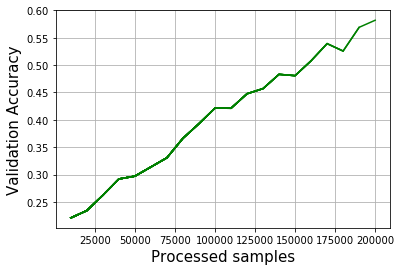

In [12]:
%%time
## If you get an error, remove this line! It makes the error message hard to understand.

# setting up running parameters
val_interval = 5000
samples_to_process = 2e5
samples_processed = 0
samples_val = []
costs, accs_val = [], []
plt.figure()
try:
    while samples_processed < samples_to_process:
        # load data
        X_tr, X_len_tr, t_in_tr, t_out_tr, t_len_tr, t_mask_tr, \
        text_inputs_tr, text_targets_in_tr, text_targets_out_tr = \
            get_batch(batch_size=BATCH_SIZE,max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
        # make fetches
        fetches_tr = [train_op, loss, accuracy]
        # set up feed dict
        feed_dict_tr = {Xs: X_tr, X_len: X_len_tr, ts_in: t_in_tr,
             ts_out: t_out_tr, t_len: t_len_tr, t_mask: t_mask_tr}
        # run the model
        res = tuple(sess.run(fetches=fetches_tr, feed_dict=feed_dict_tr))
        _, batch_cost, batch_acc = res
        costs += [batch_cost]
        samples_processed += BATCH_SIZE
        #if samples_processed % 1000 == 0: print(batch_cost, batch_acc)
        #validation data
        if samples_processed % val_interval == 0:
            #print("validating")
            fetches_val = [accuracy_valid, y_valid]
            feed_dict_val = {Xs: X_val, X_len: X_len_val, ts_in: t_in_val,
             ts_out: t_out_val, t_len: t_len_val, t_mask: t_mask_val}
            res = tuple(sess.run(fetches=fetches_val, feed_dict=feed_dict_val))
            acc_val, output_val = res
            samples_val += [samples_processed]
            accs_val += [acc_val]
            plt.plot(samples_val, accs_val, 'g-')
            plt.ylabel('Validation Accuracy', fontsize=15)
            plt.xlabel('Processed samples', fontsize=15)
            plt.title('', fontsize=20)
            plt.grid('on')
            plt.savefig("out.png")
            display.display(display.Image(filename="out.png"))
            display.clear_output(wait=True)
except KeyboardInterrupt:
    pass

print('Done')

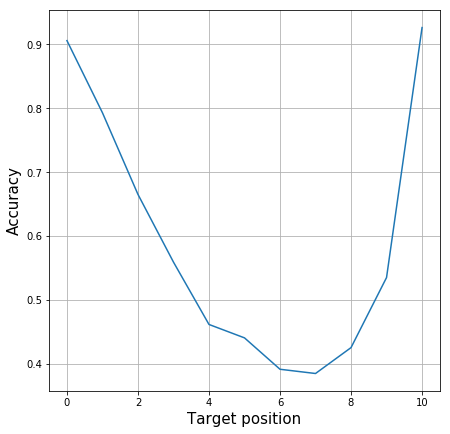

In [13]:
#plot of validation accuracy for each target position
plt.figure(figsize=(7,7))
masked_output_val = np.ma.array(np.argmax(output_val,axis=2)==t_out_val, mask=1-t_mask_val)
plt.plot(np.ma.mean(masked_output_val, axis=0))
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Target position', fontsize=15)
#plt.title('', fontsize=20)
plt.grid('on')
plt.show()
#why do the plot look like this?

In [14]:
## Save model
# Read more about saving and loading models at https://www.tensorflow.org/programmers_guide/saved_model

# Save model
save_path = tf.train.Saver().save(sess, "/tmp/model.ckpt")
print("Model saved in file: %s" % save_path)


Model saved in file: /tmp/model.ckpt


In [15]:
## Close the session, and free the resources
sess.close()

# Exercises:


### Exercise 1)
1. What is the final validation performance? 

1. Why do you think it is not better?

1. Comment on the accuracy for each position in of the output symbols?

___
Answer:
2. What is the final validation performance? 

The final accuracy is around 60%. When we see it distributed in the positions, we see that the initial and final positions have the highest accuracy.

2. Why do you think it is not better?

The 2 main reasons why it is not better is first because the training has not converged, it can be seen that the trend indicates that the accuracy of the system can improve if trained further. Also, due to the teacher forcing, if we have a mistake in the early decoded numbers, it propagates to the prediction of the rest of the numbers of the sequence.

Also, this might not be the best scheme to use since the prediciton of one of the output digits is actually independent of the surrounding ones. In a perfect scheme, the surrounding names should not give info. In this case, we have a scheme in which the hidden representation will somehow encode the output numbers to output and their position, thus giving the previous number can give information on what is the next number to output. It is as if that "teaching number" that we give as input is an "index" of the actual number to output, using the hidden state.

2. Comment on the accuracy for each position in of the output symbols?

As we can see, at the beggining we have a big accuracy, the network does well predicting the first sample, but not perfect. For this sample, the input symbol is # so the network has correctly learn to output the first number when that input is given. For the few next predictions the accuracy decreases, since the error of the first number is propagated, as we can see, the accuracy decreases linearly. Then the latest positions have an increased accuracy.

The 11-th position has accuracy almost 100%, since it will always be # whenever the chain has 10 digits. The minimum number of digits to predict is 5 and maximum is 10. When we have less than 10, the last position is also #. We later use a mask so that the other characters do not count towards accuracy. So the position from 6 to 10 will sometimes have the # character, and sometimes they will have a number, the bigger the position, the bigger the probability of # instead of a number, so the entropy of the position decreases, then its classification is easier and therefore the accuracy increases.


### Exercise 2)
The model has two GRU networks. The ```GRUEncoder``` and the ```GRUDecoder```.
A GRU is parameterized by a update gate $u$, a  reset gate $r$, the cell $c$, and the hidden state $h$:

![](images/GRUeq.png)
*Equations as described in the [Lasagne GRU documentation](http://lasagne.readthedocs.io/en/latest/modules/layers/recurrent.html#lasagne.layers.GRULayer).*

**Note** that the notation in the implementation (`tf_utils.py`) $z$ is used instead of $u$.

Under normal circumstances, such as in the TensorFlow GRUCell implementation, these gates have been stacked for faster computation, but in the custom decoder each weight and bias are as described in the original [article for GRU](https://arxiv.org/abs/1406.1078).
 1. Try to explain the shape of $W_{xr}$ and $W_{hr}$.
 1. Why are they different? 

___
Answer:

$W_{xr}$ corresponds to the input weights of the hidden neurons that connect with the original input. The shape of $W_{xr}$ is given by the size of the input and the size of the hidden state, in this case the number of hidden nerons: 16. The dimensionality of the input is 8 because we transformed the 27-one-hot sparse representation into a 8-dimensional representation with a neural network.

$W_{hr}$ corresponds to the input weights of the hidden neurons that connect with the previous state. The shape of $W_{hr}$ is given by the size of the previous hidden state and the number of hidden neurons of the network. In this case 16. The dimensionality of the state does not change with time and is equal to the number of hidden neurons 16.

They are different because they connect data with different dimensionality to the hidden neurons.

### Exercise 3)
The GRU-unit is able to ignore the input and just copy the previous hidden state.
In the beginning of training this might be desireable behaviour because it helps the model learn long range dependencies.
You can make the model ignore the input by modifying initial bias values.
1. What bias would you modify and how would you modify it?

Again you'll need to refer to the [GRU equations](http://lasagne.readthedocs.io/en/latest/modules/layers/recurrent.html#lasagne.layers.GRULayer)
Further, if you look into `tf_utils.py` and search for the `decoder(...)` function, you will see that the init for each weight and bias can be changed.

___
Answer:

The most straight forward way to ignore the input is just forcing the system to output the previous state $h_{t-1}$. Looking at the equations below:

![](images/GRUeq.png)

% We can see that this happens when $u_t = 0$. we can force this in the equation by making $b_u$ very negatively big. This way no matter the value of $x_t$ and $h_{t-1}$ (as long as it is not hugely possitive), then  $h_t = h_{t-1}$


### Exercise 4)
In the example we stack a softmax layer on top of a Recurrent layer. In the code snippet below explain how we can do that?
___
Answer: 

So, starting from the beggining we have 16 chain batches where every chain has 140 characters encoded with a one-hot 40-dimensional represenation. In the Forward Pass, each of these 16x140 characters generates the 10-length hidden state. Since the softmax layer only accepts 2D representations, what we do is using reshape, concatenating all of those 10-dimensional hidden states. Where 10 correspond to each of the dimensions of the hidden state and then 2240 is the concatenation of every value that it had for each of the 140 samples per 16 chains. Then the output layer has 11 dimensions, so the output per each state possible hidden state has dimension 11, that is the dimension of l_softmax_. And after that, we rearrange the predicted values (11-d) of each hidden state, which correponds to each sample, back to the original distribution where we know to which sample belongs each 11-d output. 


In [16]:
tf.reset_default_graph()

bs_, seqlen_, numinputs_ = 16, 140, 40 # Batch_size, Sequence_length, number_of_inputs
x_pl_ = tf.placeholder(tf.float32, [bs_, seqlen_, numinputs_])
gru_cell_ = tf.nn.rnn_cell.GRUCell(10)
l_gru_, gru_state_ = tf.nn.dynamic_rnn(gru_cell_, x_pl_, dtype=tf.float32)
l_reshape_ = tf.reshape(l_gru_, [-1, 10])

l_softmax_ = tf.contrib.layers.fully_connected(l_reshape_, 11, activation_fn=tf.nn.softmax)
l_softmax_seq_ = tf.reshape(l_softmax_, [bs_, seqlen_, -1])

print("l_input_\t", x_pl_.get_shape())
print("l_gru_\t\t", l_gru_.get_shape())
print("l_reshape_\t", l_reshape_.get_shape())
print("l_softmax_\t", l_softmax_.get_shape())
print("l_softmax_seq_\t", l_softmax_seq_.get_shape())

l_input_	 (16, 140, 40)
l_gru_		 (16, 140, 10)
l_reshape_	 (2240, 10)
l_softmax_	 (2240, 11)
l_softmax_seq_	 (16, 140, 11)


### Optional Exercise 1)
Why do you think the validation performance looks more "jig-saw" like compared to FFN and CNN models?

___
Answer:

### Optional Exercise 2)
You are interested in doing sentiment analysis on tweets, i.e classification as positive or negative. You decide read over the twitter seqeuence and use the last hidden state to do the classification. How can you modify the small network above to only output a single classification for network? Hints: look at the gru\_state\_ or the [tf.slice](https://www.tensorflow.org/versions/r0.10/api_docs/python/array_ops.html#slice) in the API.




### Optional Exercise 3)
Bidirectional Encoders are usually implemented by running a forward model and  a backward model (a forward model on a reversed sequence) separately and the concatenating them before parsing them on to the next layer. To reverse the sequence try looking at [tf.reverse_sequence](https://www.tensorflow.org/versions/r0.10/api_docs/python/array_ops.html#reverse_sequence)

Implement a Bidirectional encoder model.
Here is some code to get you started:

``` python
enc_cell = tf.nn.rnn_cell.GRUCell(NUM_UNITS_ENC)
_, enc_state = tf.nn.dynamic_rnn(cell=enc_cell, inputs=X_embedded,
                                 sequence_length=X_len, dtype=tf.float32, scope="rnn_forward")
X_embedded_backwards = tf.reverse_sequence(X_embedded, tf.to_int64(X_len), 1)
enc_cell_backwards = tf.nn.rnn_cell.GRUCell(NUM_UNITS_ENC)
_, enc_state_backwards = tf.nn.dynamic_rnn(cell=enc_cell_backwards, inputs=X_embedded_backwards,
                                 sequence_length=X_len, dtype=tf.float32, scope="rnn_backward")

enc_state = tf.concat(1, [enc_state, enc_state_backwards])
```

Note: you will need to double the NUM_UNITS_DEC, as it currently does not support different sizes.

# Book's Exercise

This exercise belongs to chapter 3 in the book

As discussed above, one way of expanding the MNIST training data is to use small rotations of training images. What's a problem that might occur if we allow arbitrarily large rotations of training images?

### Answer

This small rotations could help the network be rotation invariant, being able to detect numbers that are rotated to some degree, this follows the human intuition that a number slightly rotated is fundamentally the same number. The problem is that in our number representation, the number 6 is equal to the number 9 rotates 180 degrees. It can be confusing as well to classify some numbers if they are too much rotated. So we should contraint the number of degrees of the rotation.
